# RP dataset

Model: ResLogit Model, 1-layer, 16 hidden units


We import the dataset into the `cmt.Database()` class and indicate the choice column in the argument `choiceVar`.

In [1]:
import os
import pandas as pd
import pycmtensor as cmt
cmt.__version__
cmt.logger.set_level(cmt.logger.ERROR)

In [2]:
import os
import pandas as pd

# read csv file and set columns to UPPERCASE
nb_path = os.path.abspath("")
df_rp = pd.read_csv("../../data/model_average_RP.csv")
df_rp.columns = df_rp.columns.str.upper()

# expand categorical variables to dummy variables
df_rp["PURPOSE_WORK"] = 0
df_rp["PURPOSE_HOME"] = 0
df_rp["PURPOSE_LEISURE"] = 0
df_rp.loc[df_rp["PURPOSE"].str.split(" ", expand=True)[0] == "Work", "PURPOSE_WORK"] = 1
df_rp.loc[df_rp["PURPOSE"].str.split(" ", expand=True)[0] == "Home", "PURPOSE_HOME"] = 1
df_rp.loc[
    df_rp["PURPOSE"].isin(
        [
            "Cinema or other night out",
            "Clothes shopping",
            "Family Activity",
            "Leisure Other",
            "Museum/cultural",
            "Social",
            "Restaurant",
            "Sports activity",
            "Shopping - Major",
        ]
    ),
    "PURPOSE_LEISURE",
] = 1

df_rp["WEEKEND"] = 0
df_rp.loc[df_rp["DAY_OF_THE_WEEK_START"].isin(["Saturday", "Sunday"]), "WEEKEND"] = 1
df_rp.drop(["PURPOSE", "DAY_OF_THE_WEEK_START"], axis=1, inplace=True)
df_rp.fillna(0, inplace=True)

# load database
db = cmt.Database("model_average_rp", df_rp, choiceVar="CHOICE")
globals().update(db.variables)

# Data preparation
We perform some data cleaning and setting the choices to start from index 0.

In [3]:

# additional steps to format database
db.data["CHOICE"] -= 1
for i in [
    "TOTAL_CAR_COST",
    "BUS_COST_TOTAL_PER_LEG",
    "RAIL_COST_TOTAL_PER_LEG",
    "TAXI_COST",
]:
    db.data[i] /= 100.0

for i in [
    "CAR_DISTANCE_KM",
    "BUS_DISTANCE_KM",
    "RAIL_DISTANCE_KM",
    "TAXI_DISTANCE_KM",
    "CYCLING_DISTANCE_KM",
    "WALKING_DISTANCE_KM",
]:
    db.data[i] /= 100.0

for i in [
    "CAR_TRAVEL_TIME_MIN",
    "BUS_TRAVEL_TIME_MIN",
    "RAIL_TRAVEL_TIME_MIN",
    "TAXI_TRAVEL_TIME_MIN",
    "CYCLING_TRAVEL_TIME_MIN",
    "WALKING_TRAVEL_TIME_MIN",
    "BUS_IVT_TIME_MIN",
    "BUS_ACCESS_EGRESS_TIME_MIN",
    "RAIL_IVT_TIME_MIN",
    "RAIL_ACCESS_EGRESS_TIME_MIN",
]:
    db.data[i] /= 60.0


# Model specification
from the `pycmtensor` library, we import two classes to help us define the betas and (neural network) weights.

In [4]:
from pycmtensor.expressions import Beta, Weights
from pycmtensor import aet

# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_dist = Beta("b_dist", 0.0, None, None, 0)

b_IVT = Beta("b_IVT", 0.0, None, None, 0)
b_egress = Beta("b_egress", 0.0, None, None, 0)
b_transfers = Beta("b_transfers", 0.0, None, None, 0)

b_ncar = Beta("b_ncar", 0.0, None, None, 0)
b_nbicycle = Beta("b_nbicycle", 0.0, None, None, 0)

b_weekend_car = Beta("b_weekend_car", 0.0, None, None, 0)
b_weekend_pt = Beta("b_weekend_pt", 0.0, None, None, 0)
b_weekend_phys = Beta("b_weekend_phys", 0.0, None, None, 0)

b_cleeds_car = Beta("b_cleeds_car", 0.0, None, None, 0)
b_cleeds_pt = Beta("b_cleeds_pt", 0.0, None, None, 0)
b_cleeds_phys = Beta("b_cleeds_phys", 0.0, None, None, 0)

b_female_car = Beta("b_female_car", 0.0, None, None, 0)
b_female_pt = Beta("b_female_pt", 0.0, None, None, 0)
b_female_phys = Beta("b_female_phys", 0.0, None, None, 0)

b_age_car = Beta("b_age_car", 0.0, None, None, 0)
b_age_pt = Beta("b_age_pt", 0.0, None, None, 0)
b_age_phys = Beta("b_age_phys", 0.0, None, None, 0)

b_uk_car = Beta("b_uk_car", 0.0, None, None, 0)
b_uk_pt = Beta("b_uk_pt", 0.0, None, None, 0)
b_uk_phys = Beta("b_uk_phys", 0.0, None, None, 0)

b_edu_gba_car = Beta("b_edu_gba_car", 0.0, None, None, 0)
b_edu_gba_pt = Beta("b_edu_gba_pt", 0.0, None, None, 0)
b_edu_gba_phys = Beta("b_edu_gba_phys", 0.0, None, None, 0)

b_n_emp_car = Beta("b_n_emp_car", 0.0, None, None, 0)
b_n_emp_pt = Beta("b_n_emp_pt", 0.0, None, None, 0)
b_n_emp_phys = Beta("b_n_emp_phys", 0.0, None, None, 0)

b_mar_car = Beta("b_mar_car", 0.0, None, None, 0)
b_mar_pt = Beta("b_mar_pt", 0.0, None, None, 0)
b_mar_phys = Beta("b_mar_phys", 0.0, None, None, 0)

b_hhsize_car = Beta("b_hhsize_car", 0.0, None, None, 0)
b_hhsize_pt = Beta("b_hhsize_pt", 0.0, None, None, 0)
b_hhsize_phys = Beta("b_hhsize_phys", 0.0, None, None, 0)

b_ppinc_lt30k_car = Beta("b_ppinc_lt30k_car", 0.0, None, None, 0)
b_ppinc_lt30k_pt = Beta("b_ppinc_lt30k_pt", 0.0, None, None, 0)
b_ppinc_lt30k_phys = Beta("b_ppinc_lt30k_phys", 0.0, None, None, 0)

b_hhinc_lt50k_car = Beta("b_hhinc_lt50k_car", 0.0, None, None, 0)
b_hhinc_lt50k_pt = Beta("b_hhinc_lt50k_pt", 0.0, None, None, 0)
b_hhinc_lt50k_phys = Beta("b_hhinc_lt50k_phys", 0.0, None, None, 0)

b_ft_car = Beta("b_ft_car", 0.0, None, None, 0)
b_ft_pt = Beta("b_ft_pt", 0.0, None, None, 0)
b_ft_phys = Beta("b_ft_phys", 0.0, None, None, 0)

asc_car = Beta("asc_car", 0.0, None, None, 1)
asc_bus = Beta("asc_bus", 0.0, None, None, 0)
asc_rail = Beta("asc_rail", 0.0, None, None, 0)
asc_taxi = Beta("asc_taxi", 0.0, None, None, 0)
asc_cycling = Beta("asc_cycling", 0.0, None, None, 0)
asc_walking = Beta("asc_walking", 0.0, None, None, 0)

# 1: car, 2: bus, 3: rail, 4: taxi, 5: cycling, 6: walking.
# specify weight parameters
W1 = Weights("ResNet_01a", (6, 16), 0, True)
W2 = Weights("ResNet_01b", (16, 6), 0, True)

We specify the utility functions for the six choices respectively as `U_1`, `U_2`, `U_3`, `U_4,`, `U_5`, and `U_6`.

In [5]:
U_1 = (
    b_cost * db["TOTAL_CAR_COST"]
    + b_time * db["CAR_TRAVEL_TIME_MIN"]
    + b_dist * db["CAR_DISTANCE_KM"]
    + b_ncar * db["N_CAR"]
    + b_weekend_car * db["WEEKEND"]
    + b_cleeds_car * db["CITY.LEEDS"]
    + b_female_car * db["FEMALE"]
    + b_age_car * (db["AGE"] <= 3)  # age < 30
    + b_uk_car * (db["BRITISH_ORIGIN"])
    # + b_edu_gba_car * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_car * db["NB_HH_EMPLOYED"]
    # + b_mar_car * aet.eq(db["MAR"], 2) # married
    + b_hhsize_car * db["HH_SIZE"]
    # + b_hhinc_lt50k_car * (db["INCOME_HH"] <= 5)
    # + b_ppinc_lt30k_car * (db["INCOME_PERSO"] <= 3)
    + b_ft_car * db["OCC_FULL_TIME"]
    + asc_car
)

U_2 = (
    b_cost * db["BUS_COST_TOTAL_PER_LEG"]
    + b_time * db["BUS_TRAVEL_TIME_MIN"]
    + b_dist * db["BUS_DISTANCE_KM"]
    + b_IVT * db["BUS_IVT_TIME_MIN"]
    + b_egress * db["BUS_ACCESS_EGRESS_TIME_MIN"]
    + b_transfers * db["BUS_TRANSFERS"]
    + b_weekend_pt * db["WEEKEND"]
    # + b_cleeds_pt * db["CITY.LEEDS"]
    # + b_female_pt * db["FEMALE"]
    + b_age_pt * (db["AGE"] <= 3)  # age < 30
    + b_uk_pt * (db["BRITISH_ORIGIN"])
    + b_edu_gba_pt * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_pt * db["NB_HH_EMPLOYED"]
    + b_mar_pt * aet.eq(db["MAR"], 2)  # married
    + b_hhsize_pt * db["HH_SIZE"]
    + b_hhinc_lt50k_pt * (db["INCOME_HH"] <= 5)
    # + b_ppinc_lt30k_pt * (db["INCOME_PERSO"] <= 3)
    + b_ft_pt * db["OCC_FULL_TIME"]
    + asc_bus
)

U_3 = (
    b_cost * db["RAIL_COST_TOTAL_PER_LEG"]
    + b_time * db["CAR_TRAVEL_TIME_MIN"]
    + b_dist * db["RAIL_DISTANCE_KM"]
    + b_IVT * db["RAIL_IVT_TIME_MIN"]
    + b_egress * db["RAIL_ACCESS_EGRESS_TIME_MIN"]
    + b_transfers * db["RAIL_TRANSFERS"]
    + b_weekend_pt * db["WEEKEND"]
    # + b_cleeds_pt * db["CITY.LEEDS"]
    # + b_female_pt * db["FEMALE"]
    + b_age_pt * (db["AGE"] <= 3)
    + b_uk_pt * (db["BRITISH_ORIGIN"])
    + b_edu_gba_pt * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_pt * db["NB_HH_EMPLOYED"]
    + b_mar_pt * aet.eq(db["MAR"], 2)
    + b_hhsize_pt * db["HH_SIZE"]
    + b_hhinc_lt50k_pt * (db["INCOME_HH"] <= 5)
    # + b_ppinc_lt30k_pt * (db["INCOME_PERSO"] <= 3)
    + b_ft_pt * db["OCC_FULL_TIME"]
    + asc_rail
)

U_4 = (
    b_cost * db["TAXI_COST"]
    + b_time * db["TAXI_TRAVEL_TIME_MIN"]
    + b_dist * db["TAXI_DISTANCE_KM"]
    + asc_taxi
)

U_5 = (
    b_time * db["CYCLING_TRAVEL_TIME_MIN"]
    + b_dist * db["CYCLING_DISTANCE_KM"]
    + b_nbicycle * db["N_BICYCLE"]
    + b_weekend_phys * db["WEEKEND"]
    # + b_cleeds_phys * db["CITY.LEEDS"]
    + b_female_phys * db["FEMALE"]
    + b_age_phys * (db["AGE"] <= 3)
    # + b_uk_phys * (db["BRITISH_ORIGIN"])
    + b_edu_gba_phys * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_phys * db["NB_HH_EMPLOYED"]
    + b_mar_phys * aet.eq(db["MAR"], 2)
    # + b_hhsize_phys * db["HH_SIZE"]
    + b_hhinc_lt50k_phys * (db["INCOME_HH"] <= 5)
    + b_ppinc_lt30k_phys * (db["INCOME_PERSO"] <= 3)
    + b_ft_phys * db["OCC_FULL_TIME"]
    + asc_cycling
)

U_6 = (
    b_time * db["WALKING_TRAVEL_TIME_MIN"]
    + b_dist * db["WALKING_DISTANCE_KM"]
    + b_weekend_phys * db["WEEKEND"]
    # + b_cleeds_phys * db["CITY.LEEDS"]
    + b_female_phys * db["FEMALE"]
    + b_age_phys * (db["AGE"] <= 3)
    # + b_uk_phys * (db["BRITISH_ORIGIN"])
    + b_edu_gba_phys * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_phys * db["NB_HH_EMPLOYED"]
    + b_mar_phys * aet.eq(db["MAR"], 2)
    # + b_hhsize_phys * db["HH_SIZE"]
    + b_hhinc_lt50k_phys * (db["INCOME_HH"] <= 5)
    + b_ppinc_lt30k_phys * (db["INCOME_PERSO"] <= 3)
    + b_ft_phys * db["OCC_FULL_TIME"]
    + asc_walking
)

# Associate utility functions with the list
U = [U_1, U_2, U_3, U_4, U_5, U_6]

# Associate the availability conditions with the alternatives
av = [
    db["AVAIL_CAR"],
    db["AVAIL_BUS"],
    db["AVAIL_RAIL"],
    db["AVAIL_TAXI"],
    db["AVAIL_CYCLING"],
    db["AVAIL_WALKING"],
]

Here, we apply the ResLogit structure to our utility functions. `W1` and `W2` are the input and output weights of the residual layers.

In [6]:
from pycmtensor.models import ResLogitLayer

# generate the output from the ResLogit Layer
U = ResLogitLayer(U, W1, W2).output

# Estimation
The main estimation algorithm is as follows. We apply the Adam optimization algorithms and use a batch size of 256 samples. A cyclic learning rate is applied to the training process.

In [7]:
from pycmtensor.models import MNLogit
from pycmtensor.optimizers import Adam

model = MNLogit(U, av=av, database=db, name="rp_model")
model.add_params(locals())
model.config["patience"] = 20000
model.config["max_epoch"] = 600
model.config["batch_size"] = 256
model.config["base_lr"] = 0.005
model.config["max_lr"] = 0.02
model.config["learning_scheduler"] = "CyclicLR"
model.config["cyclic_lr_step_size"] = 16

# train function
model = cmt.train(model, database=db, optimizer=Adam, save_model=False, notebook=True)

dataset: model_average_rp (n=10120)
batch size: 256
iterations per epoch: 39


Loglikelihood:  -11822.350  Score: 0.278

Epoch    0/62400:   0%|          | 0.00/62.4k [00:00<?, ?it/s]

Optimization complete with accuracy of 87.342%. Max loglikelihood reached @ epoch 513.



# Results
The results of the model are printed by calling the `Results` class on the estimated model.

In [8]:
from pycmtensor.results import Results

result = Results(model, db)
result.print_beta_statistics()
# result.print_correlation_matrix()

Results for model: rp_model
Build time: 00:02:33
Estimation time: 00:01:41
Estimation rate: 197.559 iter/s
Seed value: 1319
Number of Beta parameters: 39
Tensor size: 192
Sample size: 10120
Excluded data: 0
Init loglikelihood: -11822.350
Final loglikelihood: -3678.453
Final loglikelihood reached at: epoch 513
Likelihood ratio test: 16287.792
Accuracy: 87.342%
Rho square: 0.689
Rho bar square: 0.669
Akaike Information Criterion: 7818.91
Bayesian Information Criterion: 9487.25
Final gradient norm: 0.044

Statistical Analysis:
                        Value   Std err     t-test   p-value Rob. Std err  Rob. t-test Rob. p-value
asc_bus             -0.262344  0.196595  -1.334437  0.182061     0.124171    -2.112759     0.034621
asc_cycling         -2.567891    0.1035  -24.81045       0.0     0.014319  -179.336744          0.0
asc_rail             1.178392  0.199975   5.892682       0.0     0.115544    10.198639          0.0
asc_taxi            -2.105033   0.10007 -21.035658       0.0     0.029

Optionally, we can plot the estimation performance vs. the number of iterations. Note that the x-axis is on a log-scale.

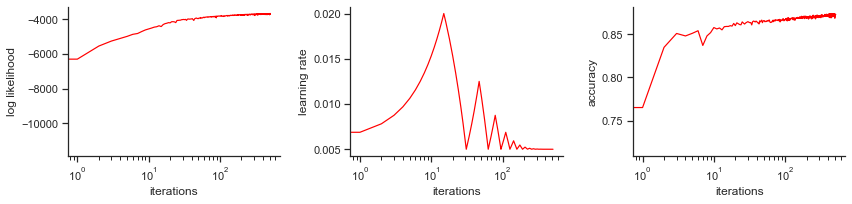

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color="red")
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color="red")
g3 = sns.lineplot(
    ax=axs[0, 2], data=log, x=log.index, y="score", color="red"
)  # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()


## Output choice probabilites
To generate the probability outputs, we call the `Predict` class on the model `model` and the database `db`. Two methods are used: `probs()` to generate the probabilities and `choices()` to generate a pseudo-choice output by selecting the choice with the highest probability. The code below concatenates the probabilities and choices together.

In [10]:
from pycmtensor.results import Predict

pd.concat((Predict(model, db).probs(), Predict(model, db).choices()), axis=1)

,0,1,2,3,4,5,CHOICE
0,0.709720,0.114197,0.174521,0.001562,0.000000,0.000000,0
1,0.000000,0.000000,0.585280,0.243376,0.171344,0.000000,2
2,0.754452,0.127397,0.112303,0.005847,0.000000,0.000000,0
3,0.000000,0.038858,0.000000,0.000000,0.000000,0.961142,5
4,0.000000,0.000000,0.989878,0.010122,0.000000,0.000000,2
...,...,...,...,...,...,...,...
10115,0.979019,0.002562,0.000000,0.007172,0.011247,0.000000,0
10116,0.952281,0.001694,0.000000,0.004421,0.007767,0.033836,0
10117,0.956549,0.011613,0.000000,0.004340,0.003815,0.023683,0
10118,0.849652,0.006432,0.000000,0.004266,0.000000,0.139650,0


## Elasticites
We can calculate the elasticities from the model too.

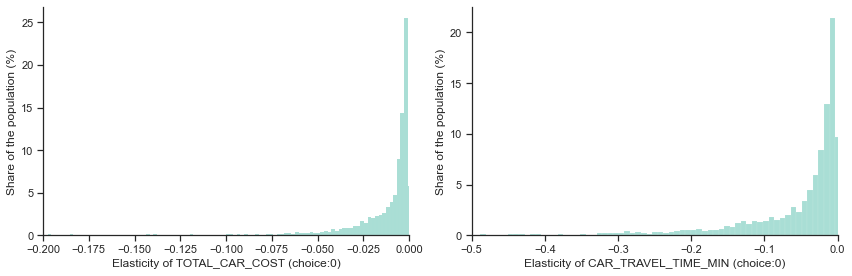

In [15]:
els_0_CC = model.elasticities(prob_choice=0, wrt="TOTAL_CAR_COST", database=db)
els_0_CT = model.elasticities(prob_choice=0, wrt="CAR_TRAVEL_TIME_MIN", database=db)

# plot histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
e1 = sns.histplot(els_0_CC, ax=axs[0, 0], stat="percent")
e2 = sns.histplot(els_0_CT, ax=axs[0, 1], stat="percent")
e1.set(xlabel="Elasticity of TOTAL_CAR_COST (choice:0)", ylabel="Share of the population (%)", xlim=[-0.2, 0.])
e2.set(xlabel="Elasticity of CAR_TRAVEL_TIME_MIN (choice:0)", ylabel="Share of the population (%)", xlim=[-0.5, 0.])
sns.despine()
plt.tight_layout()
plt.show()